### Activation Layer (LUT and Testbench)

In [1]:
import numpy as np

# Konfigurasi Q6.10
FRAC_BITS = 10
SCALE = 2 ** FRAC_BITS
TABLE_SIZE = 1024  # Kita pakai 1024 baris tabel (10-bit address)

# Range input yang akan dicover oleh tabel
# Sigmoid aktif di kisaran -4 s.d 4
# Tanh aktif di kisaran -2 s.d 2 (kita samakan -4 s.d 4 biar modulnya seragam)
MIN_VAL = -4.0
MAX_VAL = 4.0
step = (MAX_VAL - MIN_VAL) / TABLE_SIZE

def float_to_q6_10(val):
    # Convert float ke integer representasi Q6.10
    int_val = int(round(val * SCALE))
    # Handle negative (Two's complement 16-bit)
    if int_val < 0:
        int_val = (1 << 16) + int_val
    return int_val & 0xFFFF # Pastikan 16 bit

print("Generating Look-Up Tables...")

# --- 1. Generate Sigmoid ---
with open("sigmoid_lut.mem", "w") as f:
    for i in range(TABLE_SIZE):
        x = MIN_VAL + (i * step)
        sigmoid_val = 1.0 / (1.0 + np.exp(-x))
        hex_val = float_to_q6_10(sigmoid_val)
        f.write(f"{hex_val:04x}\n") # Tulis sebagai hex

# --- 2. Generate Tanh ---
with open("tanh_lut.mem", "w") as f:
    for i in range(TABLE_SIZE):
        x = MIN_VAL + (i * step)
        tanh_val = np.tanh(x)
        hex_val = float_to_q6_10(tanh_val)
        f.write(f"{hex_val:04x}\n")

print("Done! File 'sigmoid_lut.mem' dan 'tanh_lut.mem' siap dipakai.")

Generating Look-Up Tables...
Done! File 'sigmoid_lut.mem' dan 'tanh_lut.mem' siap dipakai.


In [1]:
import numpy as np
import os

# --- Configuration ---
FRAC_BITS = 10
SCALE = 2 ** FRAC_BITS
OUTPUT_DIR = "data/activation_layer_test"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "activation_input.csv")

# Ensure directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def float_to_q6_10(val):
    """Convert float to 16-bit Fixed Point Q6.10 (Two's Complement)"""
    # Scale and round
    int_val = int(round(val * SCALE))
    
    # Clamp to 16-bit range (-32768 to 32767)
    int_val = max(min(int_val, 32767), -32768)
    
    # Handle negative representation for CSV (we use standard integer)
    # Verilog $fscanf with %d handles standard signed integers (e.g., -1024)
    return int_val

# --- Generate Test Data ---
# 1. Sweep from -5.0 to 5.0 (covers saturation and active region)
sweep_data = np.linspace(-5.0, 5.0, num=100)

# 2. Add specific corner cases
corner_cases = np.array([-4.5, -4.0, -0.1, 0.0, 0.1, 4.0, 4.5])

# Combine and sort
all_floats = np.concatenate([sweep_data, corner_cases])
all_floats.sort()

# --- Convert and Save ---
print(f"Generating {len(all_floats)} test vectors...")

with open(OUTPUT_FILE, "w") as f:
    for val in all_floats:
        q_val = float_to_q6_10(val)
        # We write pure integer decimals (e.g., -500, 1024)
        f.write(f"{q_val}\n")

print(f"Success! Input data saved to: {OUTPUT_FILE}")
print("Sample data (Float -> Int):")
for i in range(5):
    print(f"{all_floats[i]:.4f} -> {float_to_q6_10(all_floats[i])}")

Generating 107 test vectors...
Success! Input data saved to: data/activation_layer_test/activation_input.csv
Sample data (Float -> Int):
-5.0000 -> -5120
-4.8990 -> -5017
-4.7980 -> -4913
-4.6970 -> -4810
-4.5960 -> -4706


/home/gswt/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Loading CSV files...
--- Summary Analysis ---
Total Samples: 107
Max Error Sigmoid: 0.017986 (approx 18.4 LSB)
Max Error Tanh   : 0.005531 (approx 5.7 LSB)


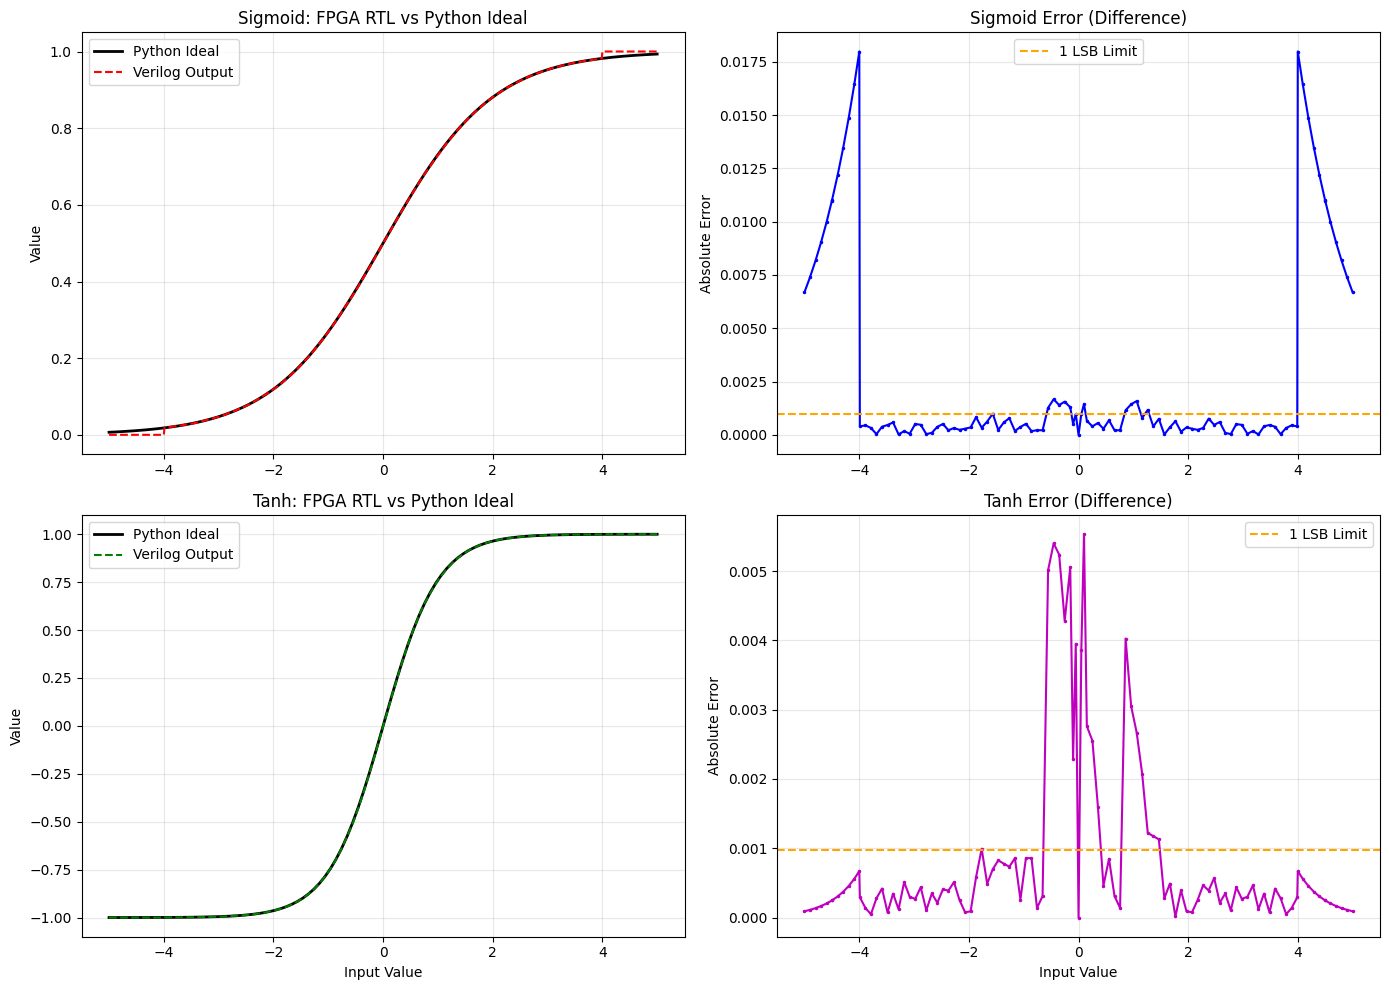

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- KONFIGURASI ---
FRAC_BITS = 10
SCALE = 2 ** FRAC_BITS

# Path file (Sesuaikan dengan struktur folder kamu)
BASE_DIR = "data/activation_layer_test"
FILE_IN  = os.path.join(BASE_DIR, "activation_input.csv")
FILE_SIG = os.path.join(BASE_DIR, "sigmoid_output.csv")
FILE_TANH= os.path.join(BASE_DIR, "tanh_output.csv")

def q6_10_to_float(int_val):
    """Mengubah Integer Q6.10 kembali ke Float"""
    return int_val / SCALE

# --- 1. LOAD DATA ---
print("Loading CSV files...")
try:
    # Header=None karena file CSV hasil Verilog tidak punya header text
    df_in = pd.read_csv(FILE_IN, header=None, names=['int_val'])
    df_sig_rtl = pd.read_csv(FILE_SIG, header=None, names=['int_val'])
    df_tanh_rtl = pd.read_csv(FILE_TANH, header=None, names=['int_val'])
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Pastikan kamu sudah menjalankan 'make run' dan file output sudah terbentuk.")
    raise

# --- 2. CONVERSION & IDEAL CALCULATION ---

# Convert Input ke Float (X Axis)
x_vals = df_in['int_val'].apply(q6_10_to_float).values

# Convert RTL Output ke Float (Y Axis - Actual FPGA)
y_sig_rtl = df_sig_rtl['int_val'].apply(q6_10_to_float).values
y_tanh_rtl = df_tanh_rtl['int_val'].apply(q6_10_to_float).values

# Hitung Ideal Output (Y Axis - Golden Reference)
# Sigmoid Ideal: 1 / (1 + e^-x)
y_sig_ideal = 1.0 / (1.0 + np.exp(-x_vals))

# Tanh Ideal: np.tanh(x)
y_tanh_ideal = np.tanh(x_vals)

# --- 3. ANALISIS ERROR ---
# Hitung selisih absolut
err_sig = np.abs(y_sig_rtl - y_sig_ideal)
err_tanh = np.abs(y_tanh_rtl - y_tanh_ideal)

print(f"--- Summary Analysis ---")
print(f"Total Samples: {len(x_vals)}")
print(f"Max Error Sigmoid: {np.max(err_sig):.6f} (approx {np.max(err_sig)*SCALE:.1f} LSB)")
print(f"Max Error Tanh   : {np.max(err_tanh):.6f} (approx {np.max(err_tanh)*SCALE:.1f} LSB)")

# --- 4. PLOTTING ---
plt.figure(figsize=(14, 10))

# === PLOT 1: SIGMOID ===
plt.subplot(2, 2, 1)
plt.title("Sigmoid: FPGA RTL vs Python Ideal")
plt.plot(x_vals, y_sig_ideal, 'k-', linewidth=2, label='Python Ideal')
plt.plot(x_vals, y_sig_rtl, 'r--', linewidth=1.5, label='Verilog Output')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylabel("Value")

plt.subplot(2, 2, 2)
plt.title("Sigmoid Error (Difference)")
plt.plot(x_vals, err_sig, 'b.-', markersize=3)
plt.axhline(1/SCALE, color='orange', linestyle='--', label='1 LSB Limit')
plt.grid(True, alpha=0.3)
plt.ylabel("Absolute Error")
plt.legend()

# === PLOT 2: TANH ===
plt.subplot(2, 2, 3)
plt.title("Tanh: FPGA RTL vs Python Ideal")
plt.plot(x_vals, y_tanh_ideal, 'k-', linewidth=2, label='Python Ideal')
plt.plot(x_vals, y_tanh_rtl, 'g--', linewidth=1.5, label='Verilog Output')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylabel("Value")
plt.xlabel("Input Value")

plt.subplot(2, 2, 4)
plt.title("Tanh Error (Difference)")
plt.plot(x_vals, err_tanh, 'm.-', markersize=3)
plt.axhline(1/SCALE, color='orange', linestyle='--', label='1 LSB Limit')
plt.grid(True, alpha=0.3)
plt.ylabel("Absolute Error")
plt.xlabel("Input Value")
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import scipy.signal
import os

# --- 1. CONFIGURATION ---
# Fixed Point Q6.10 Settings
DATA_WIDTH = 16
FRAC_BITS  = 10
SCALE      = 2 ** FRAC_BITS

# Directory Setup
BASE_DIR = "data/conv_layer_test"
os.makedirs(BASE_DIR, exist_ok=True)

# Helper Function: Float to Fixed Point (Q6.10)
def to_q6_10(x):
    # Scale float to integer
    val = int(round(x * SCALE))
    # Clamp to signed 16-bit range (-32768 to 32767) to prevent overflow
    return max(min(val, 32767), -32768)

# Helper Function: Save weights to Hex file for Verilog $readmemh
def save_weights_hex(filename, weights, bias):
    with open(filename, 'w') as f:
        # Flatten the 2D weight matrix row by row
        w_flat = weights.flatten()
        for w in w_flat:
            # Convert to Q6.10
            val = to_q6_10(w)
            # Write as 4-digit Hex (handle negative numbers using Two's Complement)
            f.write(f"{val & 0xFFFF:04x}\n")
        
        # Write Bias at the end
        val_bias = to_q6_10(bias)
        f.write(f"{val_bias & 0xFFFF:04x}\n")
    print(f"Saved weights to: {filename}")

# Helper Function: Save data to CSV
def save_csv(filename, data_array):
    # Vectorize conversion function
    v_to_q = np.vectorize(to_q6_10)
    data_q = v_to_q(data_array)
    
    # Save flattened data as standard integers
    np.savetxt(filename, data_q.flatten(), fmt='%d')
    print(f"Saved data to: {filename}")

# --- 2. GENERATE TEST FOR CONV 3x3 ---
print("\n--- Generating Conv 3x3 Data ---")
IN_SIZE_3 = 16  # Image size 16x16
K_SIZE_3  = 3

# Paths
FILE_IN_3   = os.path.join(BASE_DIR, "conv3x3_input.csv")
FILE_W_3    = os.path.join(BASE_DIR, "conv3x3_weights.txt")
FILE_REF_3  = os.path.join(BASE_DIR, "conv3x3_ref_output.csv")

# Random Input (-2.0 to 2.0)
input_3x3 = np.random.uniform(-2, 2, (IN_SIZE_3, IN_SIZE_3))

# Random Weights (-0.5 to 0.5) & Bias
weights_3x3 = np.random.uniform(-0.5, 0.5, (K_SIZE_3, K_SIZE_3))
bias_3x3    = 0.15

# Calculate Reference Output using Correlate2D (Deep Learning standard)
# Mode 'valid' means no padding output (Size will be 14x14)
ref_output_3x3 = scipy.signal.correlate2d(input_3x3, weights_3x3, mode='valid') + bias_3x3

# Save Files
save_csv(FILE_IN_3, input_3x3)
save_weights_hex(FILE_W_3, weights_3x3, bias_3x3)
save_csv(FILE_REF_3, ref_output_3x3)


# --- 3. GENERATE TEST FOR CONV 4x4 ---
print("\n--- Generating Conv 4x4 Data ---")
IN_SIZE_4 = 16  # Image size 16x16
K_SIZE_4  = 4

# Paths
FILE_IN_4   = os.path.join(BASE_DIR, "conv4x4_input.csv")
FILE_W_4    = os.path.join(BASE_DIR, "conv4x4_weights.txt")
FILE_REF_4  = os.path.join(BASE_DIR, "conv4x4_ref_output.csv")

# Random Input
input_4x4 = np.random.uniform(-2, 2, (IN_SIZE_4, IN_SIZE_4))

# Random Weights & Bias
weights_4x4 = np.random.uniform(-0.5, 0.5, (K_SIZE_4, K_SIZE_4))
bias_4x4    = -0.2

# Calculate Reference Output
# Mode 'valid' output size will be 13x13 (16 - 4 + 1)
ref_output_4x4 = scipy.signal.correlate2d(input_4x4, weights_4x4, mode='valid') + bias_4x4

# Save Files
save_csv(FILE_IN_4, input_4x4)
save_weights_hex(FILE_W_4, weights_4x4, bias_4x4)
save_csv(FILE_REF_4, ref_output_4x4)

print("\nAll generation complete!")


--- Generating Conv 3x3 Data ---
Saved data to: data/conv_layer_test/conv3x3_input.csv
Saved weights to: data/conv_layer_test/conv3x3_weights.txt
Saved data to: data/conv_layer_test/conv3x3_ref_output.csv

--- Generating Conv 4x4 Data ---
Saved data to: data/conv_layer_test/conv4x4_input.csv
Saved weights to: data/conv_layer_test/conv4x4_weights.txt
Saved data to: data/conv_layer_test/conv4x4_ref_output.csv

All generation complete!



=== VERIFIKASI CONV 3x3 ===
Max Absolute Error: 0.007812
Mean Squared Error: 0.000017


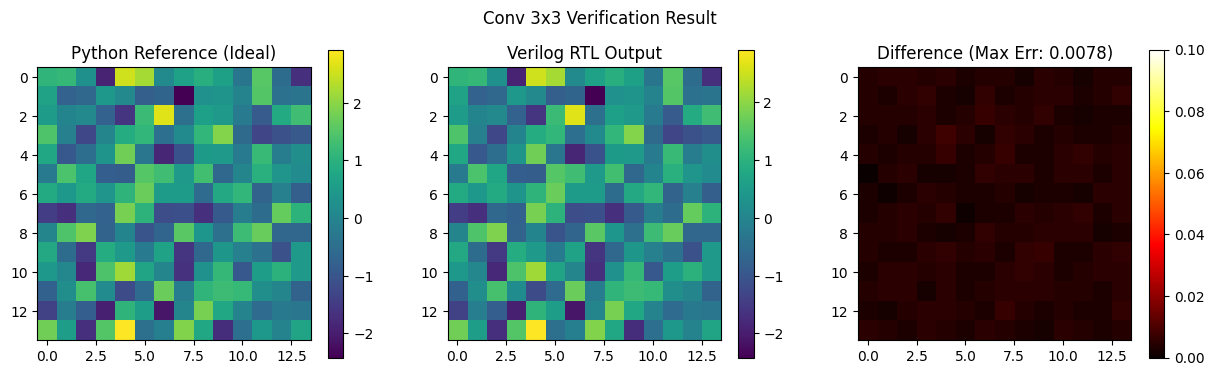


=== VERIFIKASI CONV 4x4 ===
Max Absolute Error: 0.011719
Mean Squared Error: 0.000063


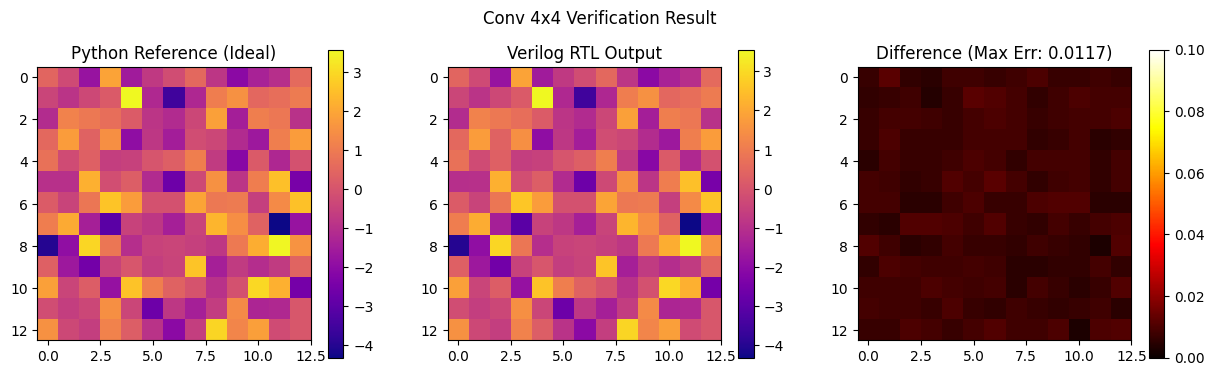

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
FRAC_BITS  = 10
SCALE      = 2 ** FRAC_BITS

# Folder tempat file berada
BASE_DIR = "data/conv_layer_test"

# Fungsi Helper: Baca CSV ke Array 2D
def load_and_reshape(filename, shape):
    try:
        data = np.loadtxt(filename, dtype=int)
        # Convert Q6.10 Integer kembali ke Float untuk plotting
        return data.reshape(shape) / SCALE
    except OSError:
        print(f"Error: File {filename} tidak ditemukan.")
        return None

# =========================================================
# VERIFIKASI 1: CONV 3x3
# =========================================================
print("\n=== VERIFIKASI CONV 3x3 ===")

# Ingat: Input 16x16, Kernel 3x3 (Valid) -> Output 14x14
OUT_SHAPE_3 = (14, 14)

# Load Files
file_rtl_3 = os.path.join(BASE_DIR, "conv3x3_rtl_output.csv")
file_ref_3 = os.path.join(BASE_DIR, "conv3x3_ref_output.csv")

rtl_3 = load_and_reshape(file_rtl_3, OUT_SHAPE_3)
ref_3 = load_and_reshape(file_ref_3, OUT_SHAPE_3)

if rtl_3 is not None and ref_3 is not None:
    # Hitung Error
    diff_3 = np.abs(rtl_3 - ref_3)
    max_err_3 = np.max(diff_3)
    mse_3 = np.mean(diff_3**2)
    
    print(f"Max Absolute Error: {max_err_3:.6f}")
    print(f"Mean Squared Error: {mse_3:.6f}")
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Reference
    im0 = axes[0].imshow(ref_3, cmap='viridis')
    axes[0].set_title("Python Reference (Ideal)")
    plt.colorbar(im0, ax=axes[0])
    
    # 2. RTL Output
    im1 = axes[1].imshow(rtl_3, cmap='viridis')
    axes[1].set_title("Verilog RTL Output")
    plt.colorbar(im1, ax=axes[1])
    
    # 3. Difference (Error)
    im2 = axes[2].imshow(diff_3, cmap='hot', vmin=0, vmax=max(0.1, max_err_3))
    axes[2].set_title(f"Difference (Max Err: {max_err_3:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    plt.suptitle("Conv 3x3 Verification Result")
    plt.show()

# =========================================================
# VERIFIKASI 2: CONV 4x4
# =========================================================
print("\n=== VERIFIKASI CONV 4x4 ===")

# Ingat: Input 16x16, Kernel 4x4 (Valid) -> Output 13x13
OUT_SHAPE_4 = (13, 13)

# Load Files
file_rtl_4 = os.path.join(BASE_DIR, "conv4x4_rtl_output.csv")
file_ref_4 = os.path.join(BASE_DIR, "conv4x4_ref_output.csv")

rtl_4 = load_and_reshape(file_rtl_4, OUT_SHAPE_4)
ref_4 = load_and_reshape(file_ref_4, OUT_SHAPE_4)

if rtl_4 is not None and ref_4 is not None:
    # Hitung Error
    diff_4 = np.abs(rtl_4 - ref_4)
    max_err_4 = np.max(diff_4)
    mse_4 = np.mean(diff_4**2)
    
    print(f"Max Absolute Error: {max_err_4:.6f}")
    print(f"Mean Squared Error: {mse_4:.6f}")
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Reference
    im0 = axes[0].imshow(ref_4, cmap='plasma')
    axes[0].set_title("Python Reference (Ideal)")
    plt.colorbar(im0, ax=axes[0])
    
    # 2. RTL Output
    im1 = axes[1].imshow(rtl_4, cmap='plasma')
    axes[1].set_title("Verilog RTL Output")
    plt.colorbar(im1, ax=axes[1])
    
    # 3. Difference (Error)
    im2 = axes[2].imshow(diff_4, cmap='hot', vmin=0, vmax=max(0.1, max_err_4))
    axes[2].set_title(f"Difference (Max Err: {max_err_4:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    plt.suptitle("Conv 4x4 Verification Result")
    plt.show()

In [13]:
import numpy as np
import scipy.signal
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
FRAC_BITS  = 10
SCALE      = 2 ** FRAC_BITS

# Kita tes dengan Input Kecil (8x8) -> Output jadi 16x16
IN_SIZE   = 8
REF_OUT_SIZE = 16 # (8 * 2) 

BASE_DIR = "data/conv_layer_test"
os.makedirs(BASE_DIR, exist_ok=True)

FILE_IN  = os.path.join(BASE_DIR, "trans_input.csv")
FILE_W   = os.path.join(BASE_DIR, "trans_weights.txt")
FILE_REF = os.path.join(BASE_DIR, "trans_ref_output.csv")

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

# --- 1. GENERATE DATA ---
print("Generating Transposed Conv Data...")

# Input: 8x8 Matrix
input_float = np.random.uniform(-1.5, 1.5, (IN_SIZE, IN_SIZE))

# Weights: 4x4 Kernel
weights_float = np.random.uniform(-0.5, 0.5, (4, 4))
bias_float    = 0.1

# --- 2. HARDWARE SIMULATION (UPSAMPLE -> CONV) ---

# A. Upsample (Zero Insertion - Full 2D)
# Ukuran array 2x lipat
upsampled_img = np.zeros((IN_SIZE * 2, IN_SIZE * 2))

# Pattern Hardware: (Data, 0, Data, 0...) dan (Baris Data, Baris Nol...)
# Artinya data asli ada di koordinat Genap, Genap
for r in range(IN_SIZE):
    for c in range(IN_SIZE):
        upsampled_img[r*2, c*2] = input_float[r, c]

# B. Convolution (Valid Mode)
# Ingat: Hardware conv4x4 kita outputnya (N - K + 1).
# Input 16x16, Kernel 4x4 -> Output 13x13.
# Jadi file reference nanti ukurannya 13x13.
ref_output = scipy.signal.correlate2d(upsampled_img, weights_float, mode='valid') + bias_float

print(f"Input Shape: {input_float.shape}")
print(f"Upsampled Shape: {upsampled_img.shape}")
print(f"Reference Output Shape: {ref_output.shape}")

# --- 3. SAVE TO FILES ---

# Save Input
v_to_q = np.vectorize(to_q6_10)
input_q = v_to_q(input_float)
np.savetxt(FILE_IN, input_q.flatten(), fmt='%d')

# Save Weights (Hex format for Verilog)
with open(FILE_W, 'w') as f:
    w_q = v_to_q(weights_float).flatten()
    for w in w_q:
        f.write(f"{w & 0xFFFF:04x}\n")
    # Bias
    b_q = to_q6_10(bias_float)
    f.write(f"{b_q & 0xFFFF:04x}\n")

# Save Reference Output
ref_q = v_to_q(ref_output)
np.savetxt(FILE_REF, ref_q.flatten(), fmt='%d')

print("Files generated successfully!")

Generating Transposed Conv Data...
Input Shape: (8, 8)
Upsampled Shape: (16, 16)
Reference Output Shape: (13, 13)
Files generated successfully!



=== VERIFIKASI TRANSPOSED CONV 4x4 ===
Max Absolute Error: 0.003906
Mean Squared Error: 0.000006
✅ HASIL SANGAT BAGUS (Error sangat kecil, hanya noise pembulatan)


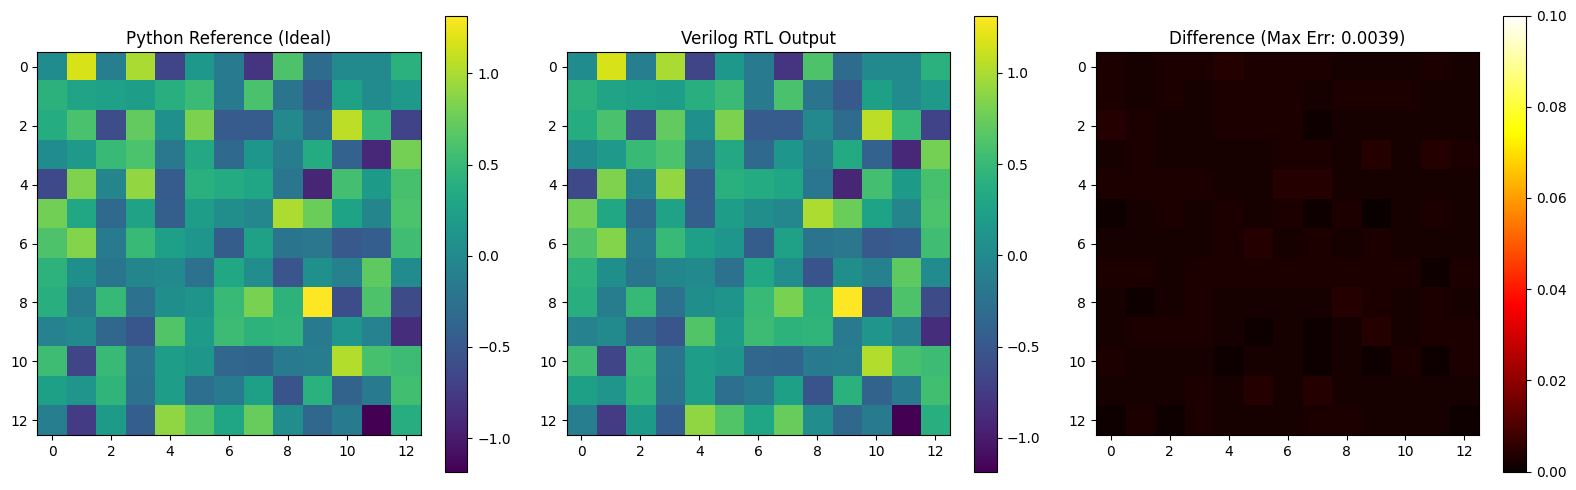

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
FRAC_BITS  = 10
SCALE      = 2 ** FRAC_BITS

# Ukuran Output yang diharapkan
# Input 8x8 -> Upsample jadi 16x16.
# Conv 4x4 (Valid) pada 16x16 -> Output (16 - 4 + 1) = 13x13.
OUT_SHAPE_TRANS = (13, 13)

# Folder
BASE_DIR = "data/conv_layer_test"
FILE_RTL = os.path.join(BASE_DIR, "trans_rtl_output.csv")
FILE_REF = os.path.join(BASE_DIR, "trans_ref_output.csv")

# Fungsi Helper
def load_and_reshape(filename, shape):
    try:
        data = np.loadtxt(filename, dtype=int)
        
        # Cek jumlah data
        expected_len = np.prod(shape)
        if data.size != expected_len:
            print(f"WARNING: File {filename} berisi {data.size} data, diharapkan {expected_len}.")
            # Jika data kurang, padding dengan 0 biar script gak crash
            if data.size < expected_len:
                data = np.pad(data, (0, expected_len - data.size), 'constant')
            # Jika data lebih, potong
            else:
                data = data[:expected_len]

        # Convert kembali ke Float untuk plotting
        return data.reshape(shape) / SCALE
    except OSError:
        print(f"Error: File {filename} tidak ditemukan. Jalankan simulasi dulu.")
        return None

# --- VERIFIKASI TRANSPOSED CONV ---
print("\n=== VERIFIKASI TRANSPOSED CONV 4x4 ===")

rtl_data = load_and_reshape(FILE_RTL, OUT_SHAPE_TRANS)
ref_data = load_and_reshape(FILE_REF, OUT_SHAPE_TRANS)

if rtl_data is not None and ref_data is not None:
    # 1. Hitung Statistik Error
    diff = np.abs(rtl_data - ref_data)
    max_err = np.max(diff)
    mse = np.mean(diff**2)
    
    print(f"Max Absolute Error: {max_err:.6f}")
    print(f"Mean Squared Error: {mse:.6f}")
    
    if max_err < 0.05:
        print("✅ HASIL SANGAT BAGUS (Error sangat kecil, hanya noise pembulatan)")
    else:
        print("⚠️ CEK KEMBALI: Error cukup signifikan.")

    # 2. Visualisasi Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot Reference (Ideal)
    im0 = axes[0].imshow(ref_data, cmap='viridis')
    axes[0].set_title("Python Reference (Ideal)")
    plt.colorbar(im0, ax=axes[0])
    
    # Plot RTL (Verilog)
    im1 = axes[1].imshow(rtl_data, cmap='viridis')
    axes[1].set_title("Verilog RTL Output")
    plt.colorbar(im1, ax=axes[1])
    
    # Plot Difference (Error Map)
    # Gunakan vmin/vmax agar error kecil tetap terlihat hitam
    im2 = axes[2].imshow(diff, cmap='hot', vmin=0, vmax=max(0.1, max_err))
    axes[2].set_title(f"Difference (Max Err: {max_err:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

In [37]:
import numpy as np
import scipy.signal
import os

DATA_WIDTH = 16
FRAC_BITS  = 10
SCALE      = 2 ** FRAC_BITS
BASE_DIR = "data/generator_test"
os.makedirs(BASE_DIR, exist_ok=True)

FILE_IN      = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")
FILE_REF     = os.path.join(BASE_DIR, "gen_ref_output.csv")

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

def leaky_relu(x, alpha=0.2): return np.where(x > 0, x, x * alpha)

def run_trans_layer(img, w, b):
    h, w_img = img.shape
    # Upsample
    up = np.zeros((h*2, w_img*2))
    for r in range(h):
        for c in range(w_img):
            up[r*2, c*2] = img[r, c]
    # Conv Valid
    return scipy.signal.correlate2d(up, w, mode='valid') + b

print("Generating Mini Generator Data (8x8 Input)...")

# Input 8x8
input_img = np.random.uniform(-1, 1, (8, 8))

# Weights
w0 = np.random.uniform(-0.5, 0.5, (4, 4)); b0 = 0.1
w1 = np.random.uniform(-0.5, 0.5, (4, 4)); b1 = -0.05
w_out = np.random.uniform(-0.5, 0.5, (3, 3)); b_out = 0.0

# Forward Pass (Python Reference)
# L0: 8x8 -> 16x16 -> 13x13
l0 = run_trans_layer(input_img, w0, b0)
act0 = leaky_relu(l0)
print(f"L0 Output: {l0.shape}")

# L1: 13x13 -> 26x26 -> 23x23
l1 = run_trans_layer(act0, w1, b1)
act1 = leaky_relu(l1)
print(f"L1 Output: {l1.shape}")

# L_Out: 23x23 -> 21x21 (Standard Conv)
l_final = scipy.signal.correlate2d(act1, w_out, mode='valid') + b_out
final_img = np.tanh(l_final)
print(f"Final Output: {final_img.shape}")

# Save Files
np.savetxt(FILE_IN, np.vectorize(to_q6_10)(input_img).flatten(), fmt='%d')
np.savetxt(FILE_REF, np.vectorize(to_q6_10)(final_img).flatten(), fmt='%d')

weights_list = []
weights_list.extend(w0.flatten()); weights_list.append(b0)
weights_list.extend(w1.flatten()); weights_list.append(b1)
weights_list.extend(w_out.flatten()); weights_list.append(b_out)

with open(FILE_WEIGHTS, 'w') as f:
    for val in weights_list:
        f.write(f"{to_q6_10(val) & 0xFFFF:04x}\n")

print("Files Ready.")

Generating Mini Generator Data (8x8 Input)...
L0 Output: (13, 13)
L1 Output: (23, 23)
Final Output: (21, 21)
Files Ready.


In [42]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
FRAC_BITS  = 10
SCALE      = 2 ** FRAC_BITS

BASE_DIR = "data/generator_test"
FILE_IN      = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")
FILE_RTL_OUT = os.path.join(BASE_DIR, "gen_rtl_output.csv")

# Fungsi Helper
def to_float(q_val):
    if q_val > 32767: q_val -= 65536
    return q_val / SCALE

def leaky_relu(x, alpha=0.2):
    return np.where(x > 0, x, x * alpha)

# Load Weights Manual (Sesuai urutan generator_tb)
# L0(17), L1(17), L2(17), Out(10) -> Total 61 lines
weights_raw = []
with open(FILE_WEIGHTS, 'r') as f:
    for line in f:
        weights_raw.append(int(line.strip(), 16))

# Helper ambil weights dari list
w_idx = 0
def get_w_b(size):
    global w_idx
    w = np.array(weights_raw[w_idx : w_idx + size*size]).reshape(size, size)
    # Convert unsigned hex back to signed int
    w = np.vectorize(to_float)(w)
    w_idx += size*size
    b = to_float(weights_raw[w_idx])
    w_idx += 1
    return w, b

w0, b0 = get_w_b(4) # L0
w1, b1 = get_w_b(4) # L1
w2, b2 = get_w_b(4) # L2
w3, b3 = get_w_b(3) # Out

# Load Input
input_raw = np.loadtxt(FILE_IN, dtype=int)
input_img = np.vectorize(to_float)(input_raw).reshape(16, 16)

# --- REKALKULASI REFERENCE (MODE VALID - MATCHING HARDWARE) ---
print("Calculating Python Reference (Valid Mode)...")

def run_layer_valid(img, w, b, is_trans=True):
    if is_trans:
        # Upsample 2x
        h, w_img = img.shape
        up = np.zeros((h*2, w_img*2))
        for r in range(h):
            for c in range(w_img):
                up[r*2, c*2] = img[r, c]
        # Conv Valid
        res = scipy.signal.correlate2d(up, w, mode='valid') + b
    else:
        # Standard Conv Valid
        res = scipy.signal.correlate2d(img, w, mode='valid') + b
    return res

# L0: 16 -> 32 -> 29
l0 = run_layer_valid(input_img, w0, b0)
l0_act = leaky_relu(l0)
print(f"L0 Out Shape: {l0.shape} (Expected 29x29)")

# L1: 29 -> 58 -> 55
l1 = run_layer_valid(l0_act, w1, b1)
l1_act = leaky_relu(l1)
print(f"L1 Out Shape: {l1.shape} (Expected 55x55)")

# L2: 55 -> 110 -> 107
l2 = run_layer_valid(l1_act, w2, b2)
l2_act = leaky_relu(l2)
print(f"L2 Out Shape: {l2.shape} (Expected 107x107)")

# L_Final: 107 -> 105
l_out = run_layer_valid(l2_act, w3, b3, is_trans=False)
ref_final = np.tanh(l_out)
print(f"Final Ref Shape: {ref_final.shape} (Expected 105x105)")

# --- VERIFIKASI ---
print("\nVerifying RTL Output...")
rtl_raw = np.loadtxt(FILE_RTL_OUT, dtype=int)
# Cek apakah jumlah data RTL pas
expected_len = ref_final.size
if rtl_raw.size != expected_len:
    print(f"WARNING: RTL Output size {rtl_raw.size} != Expected {expected_len}")
    # Crop atau Pad untuk plotting darurat
    if rtl_raw.size > expected_len: rtl_raw = rtl_raw[:expected_len]
    else: rtl_raw = np.pad(rtl_raw, (0, expected_len - rtl_raw.size))

rtl_img = np.vectorize(to_float)(rtl_raw).reshape(ref_final.shape)

# Hitung Error
diff = np.abs(rtl_img - ref_final)
print(f"Max Error: {np.max(diff):.6f}")
print(f"MSE: {np.mean(diff**2):.6f}")

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ref_final, cmap='gray'); ax[0].set_title("Python Ref (Valid Mode)")
ax[1].imshow(rtl_img, cmap='gray'); ax[1].set_title("RTL Output")
im = ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference"); plt.colorbar(im, ax=ax[2])
plt.show()

ValueError: cannot reshape array of size 10 into shape (4,4)

In [44]:
import numpy as np
import scipy.signal
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
SCALE = 2 ** 10
np.random.seed(42)  # <--- KUNCI RANDOM BIAR KONSISTEN

BASE_DIR = "data/generator_test"
os.makedirs(BASE_DIR, exist_ok=True)
FILE_IN      = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")
FILE_REF     = os.path.join(BASE_DIR, "gen_ref_output.csv") # Ini nanti isinya output Layer 0

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

def leaky_relu(x, alpha=0.2): return np.where(x > 0, x, x * alpha)

print("Generating Debug Data (Layer 0 Only)...")

# Input 8x8
input_img = np.random.uniform(-1, 1, (8, 8))

# Weights Layer 0 Only
w0 = np.random.uniform(-0.5, 0.5, (4, 4))
b0 = 0.1

# Dummy Weights (untuk Layer 1 & 2 biar file weights tetep valid formatnya)
w_dummy = np.zeros((4,4)); b_dummy = 0
w_out_dummy = np.zeros((3,3)); b_out_dummy = 0

# --- REFERENCE CALCULATION (LAYER 0 ONLY) ---
h, w_img = input_img.shape
up = np.zeros((h*2, w_img*2))
for r in range(h):
    for c in range(w_img):
        up[r*2, c*2] = input_img[r, c]

l0 = scipy.signal.correlate2d(up, w0, mode='valid') + b0
ref_layer0 = leaky_relu(l0)

print(f"Layer 0 Output Shape: {ref_layer0.shape} (Expected 13x13)")

# --- SAVE FILES ---
np.savetxt(FILE_IN, np.vectorize(to_q6_10)(input_img).flatten(), fmt='%d')
np.savetxt(FILE_REF, np.vectorize(to_q6_10)(ref_layer0).flatten(), fmt='%d')

# Save Weights (Format tetap 44 baris biar TB tidak error)
weights_list = []
# L0 (Valid)
weights_list.extend(w0.flatten()); weights_list.append(b0)
# L1 (Dummy)
weights_list.extend(w_dummy.flatten()); weights_list.append(b_dummy)
# Out (Dummy)
weights_list.extend(w_out_dummy.flatten()); weights_list.append(b_out_dummy)

with open(FILE_WEIGHTS, 'w') as f:
    for val in weights_list:
        f.write(f"{to_q6_10(val) & 0xFFFF:04x}\n")

print("Debug Files Ready.")

Generating Debug Data (Layer 0 Only)...
Layer 0 Output Shape: (13, 13) (Expected 13x13)
Debug Files Ready.


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os

DATA_WIDTH = 16
SCALE = 2 ** 10
BASE_DIR = "data/generator_test"
FILE_RTL = os.path.join(BASE_DIR, "gen_rtl_output.csv")
FILE_REF = os.path.join(BASE_DIR, "gen_ref_output.csv") # Ini Ref Layer 0 dari script di atas

def to_float(x): 
    if x > 32767: x -= 65536
    return x / SCALE

# Load Reference
ref_data = np.loadtxt(FILE_REF, dtype=int)
ref_img = np.vectorize(to_float)(ref_data).reshape(13, 13)

# Load RTL
try:
    rtl_data = np.loadtxt(FILE_RTL, dtype=int)
except:
    rtl_data = np.zeros(1)

print(f"Ref Size: {ref_img.size} (13x13)")
print(f"RTL Size: {rtl_data.size}")

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ref_img, cmap='gray'); ax[0].set_title("Ref Layer 0")

if rtl_data.size > 0:
    # Resize RTL to match Ref for visualization (pad/crop)
    rtl_show = np.zeros(ref_img.size)
    l = min(rtl_data.size, ref_img.size)
    rtl_show[:l] = rtl_data[:l]
    rtl_img = np.vectorize(to_float)(rtl_show).reshape(13, 13)
    
    ax[1].imshow(rtl_img, cmap='gray'); ax[1].set_title(f"RTL Layer 0 ({rtl_data.size} px)")
else:
    ax[1].text(0.5, 0.5, "No Data", ha='center')

plt.show()

# Cek nilai awal
if rtl_data.size > 5:
    print("\nFirst 5 Ref Vals:", ref_data[:5])
    print("First 5 RTL Vals:", rtl_data[:5])

ValueError: cannot reshape array of size 529 into shape (13,13)

In [53]:
import numpy as np
import scipy.signal
import os

DATA_WIDTH = 16
SCALE = 2 ** 10
np.random.seed(42) # Seed sama biar konsisten

BASE_DIR = "data/generator_test"
FILE_IN      = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")
FILE_REF     = os.path.join(BASE_DIR, "gen_ref_output.csv")

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

def leaky_relu(x, alpha=0.2): return np.where(x > 0, x, x * alpha)

print("Generating Debug Data (Layer 0 + 1)...")

# Input 8x8
input_img = np.random.uniform(-1, 1, (8, 8))

# Weights (L0 & L1 Valid)
w0 = np.random.uniform(-0.5, 0.5, (4, 4)); b0 = 0.1
w1 = np.random.uniform(-0.5, 0.5, (4, 4)); b1 = -0.05
w_dummy = np.zeros((3,3)); b_dummy = 0

# --- REFERENCE CALCULATION ---
def run_trans(img, w, b):
    h, w_img = img.shape
    up = np.zeros((h*2, w_img*2))
    for r in range(h):
        for c in range(w_img):
            up[r*2, c*2] = img[r, c]
    return scipy.signal.correlate2d(up, w, mode='valid') + b

# L0
l0 = run_trans(input_img, w0, b0); act0 = leaky_relu(l0)
# L1
l1 = run_trans(act0, w1, b1); act1 = leaky_relu(l1)

print(f"Layer 1 Output Shape: {act1.shape} (Expected 23x23)")

# SAVE
np.savetxt(FILE_IN, np.vectorize(to_q6_10)(input_img).flatten(), fmt='%d')
np.savetxt(FILE_REF, np.vectorize(to_q6_10)(act1).flatten(), fmt='%d')

weights_list = []
weights_list.extend(w0.flatten()); weights_list.append(b0)
weights_list.extend(w1.flatten()); weights_list.append(b1)
weights_list.extend(w_dummy.flatten()); weights_list.append(b_dummy)

with open(FILE_WEIGHTS, 'w') as f:
    for val in weights_list:
        f.write(f"{to_q6_10(val) & 0xFFFF:04x}\n")
        
print("Debug Files Ready.")

Generating Debug Data (Layer 0 + 1)...
Layer 1 Output Shape: (23, 23) (Expected 23x23)
Debug Files Ready.


In [63]:
import numpy as np
import scipy.signal
import os

# --- SETUP SAMA SEPERTI SEBELUMNYA ---
DATA_WIDTH = 16
SCALE = 2 ** 10
BASE_DIR = "data/generator_test"
FILE_IN = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")

def to_float(x): return (x - 65536 if x > 32767 else x) / SCALE
def to_q6_10(x): return int(round(x * SCALE))
def leaky_relu(x): return np.where(x > 0, x, x * 0.2) # Alpha 0.2

# LOAD
print("Checking Truth Data...")
input_raw = np.loadtxt(FILE_IN, dtype=int)
input_img = np.vectorize(to_float)(input_raw).reshape(8, 8)

weights_raw = []
with open(FILE_WEIGHTS, 'r') as f:
    for line in f: weights_raw.append(int(line.strip(), 16))

# AMBIL WEIGHTS LAYER 0
w0 = np.array(weights_raw[0:16]).reshape(4, 4); w0 = np.vectorize(to_float)(w0)
b0 = to_float(weights_raw[16])

# HITUNG MANUAL LAYER 0
# Upsample
h, w = input_img.shape
up = np.zeros((h*2, w*2))
for r in range(h):
    for c in range(w):
        up[r*2, c*2] = input_img[r, c]

# Conv
conv = scipy.signal.correlate2d(up, w0, mode='valid') + b0
# ReLU
res = leaky_relu(conv)

# PRINT 5 PIXEL PERTAMA (DALAM HEX/INT Q6.10)
print("\n--- KEBENARAN (PYTHON REF) ---")
flat = res.flatten()
for i in range(5):
    val_int = to_q6_10(flat[i])
    print(f"Pixel {i+1}: {val_int}")

print("\n--- HASIL HARDWARE KAMU ---")
print("Pixel 1: -4")
print("Pixel 2: 192")
print("Pixel 3: -14")
print("Pixel 4: 92")
print("Pixel 5: 609")

Checking Truth Data...

--- KEBENARAN (PYTHON REF) ---
Pixel 1: -38
Pixel 2: 194
Pixel 3: -137
Pixel 4: 94
Pixel 5: 610

--- HASIL HARDWARE KAMU ---
Pixel 1: -4
Pixel 2: 192
Pixel 3: -14
Pixel 4: 92
Pixel 5: 609


In [64]:
import numpy as np
import scipy.signal
import os

# --- SETUP ---
DATA_WIDTH = 16
SCALE = 2 ** 10
BASE_DIR = "data/generator_test"
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")

def to_float(x): return (x - 65536 if x > 32767 else x) / SCALE
def to_q6_10(x): return int(round(x * SCALE))
def leaky_relu(x): return np.where(x > 0, x, x * 0.203125) # Pakai approx 13/64 biar persis HW

print("--- DIAGNOSA LAYER 1 ---")

# 1. AMBIL WEIGHTS LAYER 1
weights_raw = []
with open(FILE_WEIGHTS, 'r') as f:
    for line in f: weights_raw.append(int(line.strip(), 16))

# Ingat struktur file: [L0 (16+1)] -> [L1 (16+1)]
# Offset L1 mulai dari index 17
w1_raw = np.array(weights_raw[17:33]).reshape(4, 4)
w1 = np.vectorize(to_float)(w1_raw)
b1 = to_float(weights_raw[33])

print("Weights Layer 1 (Top-Left 2x2):")
print(w1[0:2, 0:2])
print(f"Bias: {b1}")

# 2. SIMULASI INPUT DARI HARDWARE (SPY VALUES)
# Kita buat ulang input matriks 13x13 berdasarkan data SPY kamu
# Spy: -39, 192, -140, 92, 609...
# Kita isi 5 pixel pertama, sisanya 0 (karena kita cuma mau cek pixel awal)
input_sim = np.zeros((13, 13))
input_sim[0, 0] = -39/SCALE  # Pixel 1
input_sim[0, 1] = 192/SCALE  # Pixel 2
input_sim[0, 2] = -140/SCALE # Pixel 3
input_sim[0, 3] = 92/SCALE   # Pixel 4
input_sim[0, 4] = 609/SCALE  # Pixel 5

# 3. HITUNG MANUAL PROSES LAYER 1
# A. Upsample (Insert Zeros) -> Jadi 26x26
up = np.zeros((26, 26))
for r in range(13):
    for c in range(13):
        up[r*2, c*2] = input_sim[r, c]

# B. Conv Valid (Kernel 4x4)
# Output Pixel 1 (Top-Left) adalah dot product kernel dengan pojok kiri atas input
# Input Patch 4x4:
# P0  0  P1  0
# 0   0  0   0
# ...
patch = up[0:4, 0:4]
res_conv = np.sum(patch * w1) + b1
res_relu = leaky_relu(res_conv)

# 4. HASIL
val_hw = to_q6_10(res_relu)
print(f"\nInput HW Pixel 1: {input_sim[0,0]*SCALE:.0f}")
print(f"Input HW Pixel 2: {input_sim[0,1]*SCALE:.0f}")
print(f"----------------------------------------")
print(f"CALCULATED TARGET: {val_hw}")
print(f"ACTUAL HW OUTPUT : 17")

if abs(val_hw - 17) <= 5:
    print("\n✅ MATCH! Hardware Layer 1 BENAR. File Reference yang lama SALAH/BASI.")
    print("SOLUSI: Generate ulang 'gen_ref_output.csv' dengan bobot yang sekarang.")
else:
    print("\n❌ MISMATCH! Hardware Layer 1 Masih Salah.")
    print("Kemungkinan Conv2D tidak support lebar 26 (bukan kelipatan 4).")

--- DIAGNOSA LAYER 1 ---
Weights Layer 1 (Top-Left 2x2):
[[ 0.36328125  0.12304688]
 [-0.18945312 -0.17480469]]
Bias: -0.0498046875

Input HW Pixel 1: -39
Input HW Pixel 2: 192
----------------------------------------
CALCULATED TARGET: -20
ACTUAL HW OUTPUT : 17

❌ MISMATCH! Hardware Layer 1 Masih Salah.
Kemungkinan Conv2D tidak support lebar 26 (bukan kelipatan 4).


In [66]:
import numpy as np
import scipy.signal
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
SCALE = 2 ** 10
np.random.seed(42) # Seed Tetap

BASE_DIR = "data/generator_test"
os.makedirs(BASE_DIR, exist_ok=True)

# File Paths
FILE_IN      = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")
FILE_REF_L0  = os.path.join(BASE_DIR, "ref_layer0.csv")
FILE_REF_L1  = os.path.join(BASE_DIR, "ref_layer1.csv")

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

def to_float(q_val): return q_val / SCALE

# Hardware-Accurate LeakyReLU (13/64 approx 0.203125)
def leaky_relu_hw(x):
    # Simulasi shift logic: (x>>3) + (x>>4) + (x>>6)
    # Kita pakai float approx saja yang sangat dekat
    return np.where(x > 0, x, x * (13/64))

def run_trans_layer(img, w, b):
    # 1. Upsample (Insert Zero)
    h, w_img = img.shape
    up = np.zeros((h*2, w_img*2))
    for r in range(h):
        for c in range(w_img):
            up[r*2, c*2] = img[r, c]
    # 2. Conv Valid
    res = scipy.signal.correlate2d(up, w, mode='valid') + b
    return res

print("Generating Debug Data (L0 & L1)...")

# --- 1. GENERATE RANDOM INPUT & WEIGHTS ---
input_img = np.random.uniform(-1, 1, (8, 8))

# Weights L0 (4x4)
w0 = np.random.uniform(-0.5, 0.5, (4, 4)); b0 = 0.1
# Weights L1 (4x4)
w1 = np.random.uniform(-0.5, 0.5, (4, 4)); b1 = -0.05
# Dummy L_Out (3x3) - Biar file gen_weights.txt strukturnya lengkap
w_out = np.zeros((3,3)); b_out = 0

# --- 2. CALCULATE REFERENCE ---
# Layer 0 (8x8 -> 13x13)
l0_conv = run_trans_layer(input_img, w0, b0)
l0_act  = leaky_relu_hw(l0_conv)

# Layer 1 (13x13 -> 23x23)
l1_conv = run_trans_layer(l0_act, w1, b1)
l1_act  = leaky_relu_hw(l1_conv)

print(f"Ref L0 Shape: {l0_act.shape}")
print(f"Ref L1 Shape: {l1_act.shape}")

# --- 3. SAVE FILES ---
np.savetxt(FILE_IN, np.vectorize(to_q6_10)(input_img).flatten(), fmt='%d')
np.savetxt(FILE_REF_L0, np.vectorize(to_q6_10)(l0_act).flatten(), fmt='%d')
np.savetxt(FILE_REF_L1, np.vectorize(to_q6_10)(l1_act).flatten(), fmt='%d')

# Save Weights (L0, L1, Dummy)
weights_list = []
weights_list.extend(w0.flatten()); weights_list.append(b0)
weights_list.extend(w1.flatten()); weights_list.append(b1)
weights_list.extend(w_out.flatten()); weights_list.append(b_out)

with open(FILE_WEIGHTS, 'w') as f:
    for val in weights_list:
        f.write(f"{to_q6_10(val) & 0xFFFF:04x}\n")

print("Data Generated Successfully.")

Generating Debug Data (L0 & L1)...
Ref L0 Shape: (13, 13)
Ref L1 Shape: (23, 23)
Data Generated Successfully.



--- VERIFYING LAYER 0 (13x13) ---
L0 Max Error: 0.003906

--- VERIFYING LAYER 1 (23x23) ---
L1 Max Error: 0.607422


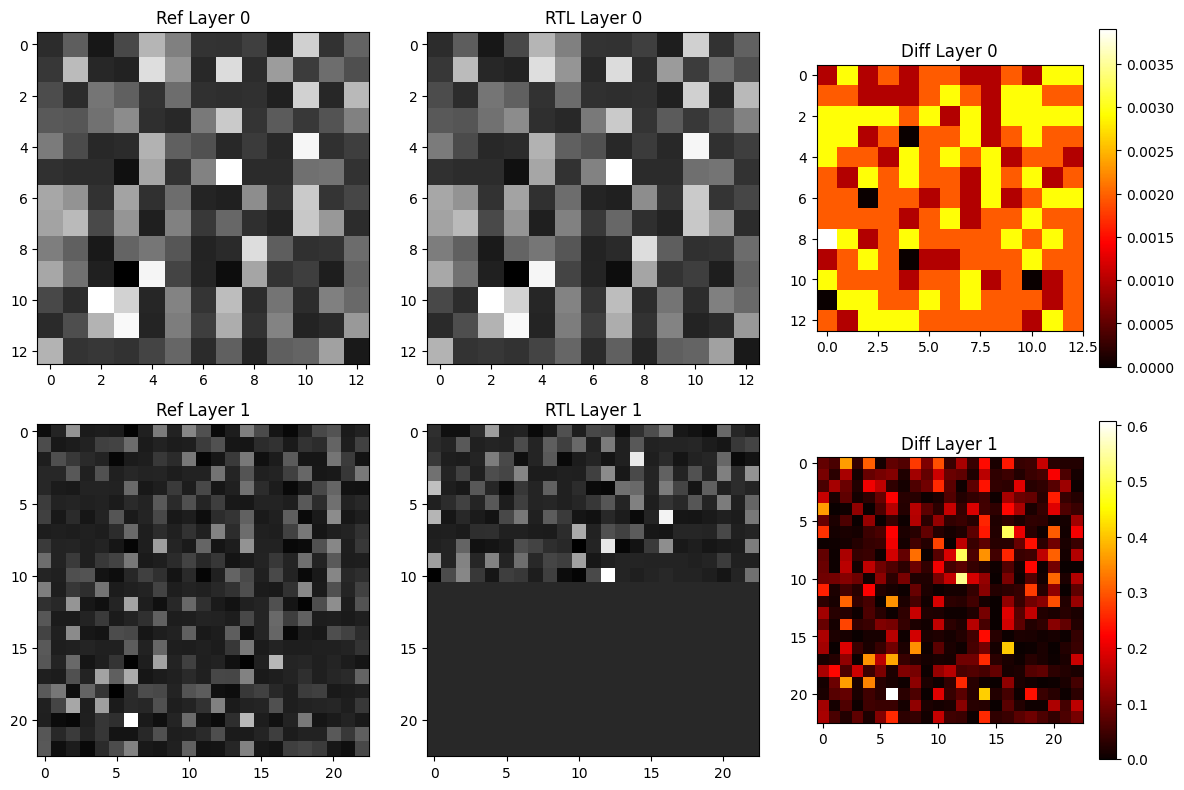

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIG ---
SCALE = 2 ** 10
BASE_DIR = "data/generator_test"

# Paths
REF_L0 = os.path.join(BASE_DIR, "ref_layer0.csv")
RTL_L0 = os.path.join(BASE_DIR, "rtl_layer0.csv")
REF_L1 = os.path.join(BASE_DIR, "ref_layer1.csv")
RTL_L1 = os.path.join(BASE_DIR, "rtl_layer1.csv")

def load_and_reshape(file_path, shape):
    try:
        data = np.loadtxt(file_path, dtype=int)
        # Pad or Crop if mismatch
        expected = shape[0] * shape[1]
        if data.size < expected:
            data = np.pad(data, (0, expected - data.size))
        elif data.size > expected:
            data = data[:expected]
        return data.reshape(shape) / SCALE
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return np.zeros(shape)

# --- VERIFY LAYER 0 ---
print("\n--- VERIFYING LAYER 0 (13x13) ---")
ref0 = load_and_reshape(REF_L0, (13, 13))
rtl0 = load_and_reshape(RTL_L0, (13, 13))
diff0 = np.abs(ref0 - rtl0)
print(f"L0 Max Error: {np.max(diff0):.6f}")

# --- VERIFY LAYER 1 ---
print("\n--- VERIFYING LAYER 1 (23x23) ---")
ref1 = load_and_reshape(REF_L1, (23, 23))
rtl1 = load_and_reshape(RTL_L1, (23, 23))
diff1 = np.abs(ref1 - rtl1)
print(f"L1 Max Error: {np.max(diff1):.6f}")

# --- PLOTTING ---
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Row 0: Layer 0
ax[0,0].imshow(ref0, cmap='gray'); ax[0,0].set_title("Ref Layer 0")
ax[0,1].imshow(rtl0, cmap='gray'); ax[0,1].set_title("RTL Layer 0")
im0 = ax[0,2].imshow(diff0, cmap='hot'); ax[0,2].set_title("Diff Layer 0"); plt.colorbar(im0, ax=ax[0,2])

# Row 1: Layer 1
ax[1,0].imshow(ref1, cmap='gray'); ax[1,0].set_title("Ref Layer 1")
ax[1,1].imshow(rtl1, cmap='gray'); ax[1,1].set_title("RTL Layer 1")
im1 = ax[1,2].imshow(diff1, cmap='hot'); ax[1,2].set_title("Diff Layer 1"); plt.colorbar(im1, ax=ax[1,2])

plt.tight_layout()
plt.show()

In [73]:
import numpy as np
import scipy.signal
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
SCALE = 2 ** 10
np.random.seed(99) # Seed baru biar fresh

# Folder Khusus Unit Test
BASE_DIR = "data/layer1_unit_test"
os.makedirs(BASE_DIR, exist_ok=True)

FILE_IN      = os.path.join(BASE_DIR, "l1_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "l1_weights.txt")
FILE_REF     = os.path.join(BASE_DIR, "l1_ref.csv")

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

def leaky_relu_hw(x):
    # Approx 13/64 matching hardware
    return np.where(x > 0, x, x * (13/64))

print("Generating Layer 1 Unit Test Data (13x13 Input)...")

# 1. Input 13x13 (Ganjil)
input_img = np.random.uniform(-1, 1, (13, 13))

# 2. Weights 4x4
w = np.random.uniform(-0.5, 0.5, (4, 4))
b = 0.25

# 3. Hitung Reference Manual
# Upsample (13x13 -> 26x26)
h, w_img = input_img.shape
up = np.zeros((h*2, w_img*2))
for r in range(h):
    for c in range(w_img):
        up[r*2, c*2] = input_img[r, c]

# Conv (Valid) -> Output 23x23
conv_res = scipy.signal.correlate2d(up, w, mode='valid') + b

# Activation
final_res = leaky_relu_hw(conv_res)

print(f"Input Shape: {input_img.shape}")
print(f"Output Shape: {final_res.shape} (Target 23x23)")

# 4. Save Files
np.savetxt(FILE_IN, np.vectorize(to_q6_10)(input_img).flatten(), fmt='%d')
np.savetxt(FILE_REF, np.vectorize(to_q6_10)(final_res).flatten(), fmt='%d')

# Save Weights (Hanya 1 set: 16 weight + 1 bias)
weights_list = []
weights_list.extend(w.flatten()); weights_list.append(b)

with open(FILE_WEIGHTS, 'w') as f:
    for val in weights_list:
        f.write(f"{to_q6_10(val) & 0xFFFF:04x}\n")

print("Files Ready in data/layer1_unit_test/")

Generating Layer 1 Unit Test Data (13x13 Input)...
Input Shape: (13, 13)
Output Shape: (23, 23) (Target 23x23)
Files Ready in data/layer1_unit_test/


Verifying Unit Test Layer 1...
Max Error: 0.003906


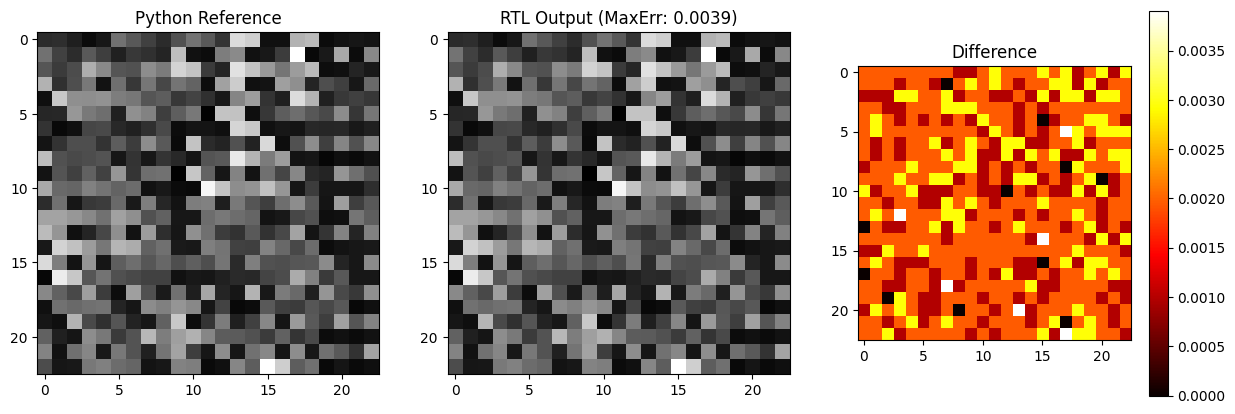

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os

SCALE = 2 ** 10
BASE_DIR = "data/layer1_unit_test"

FILE_REF = os.path.join(BASE_DIR, "l1_ref.csv")
FILE_RTL = os.path.join(BASE_DIR, "l1_rtl_out.csv")

def load_data(path, shape):
    try:
        data = np.loadtxt(path, dtype=int)
        expected = shape[0] * shape[1]
        if data.size != expected:
            print(f"WARNING: {path} size {data.size}, expected {expected}")
            # Resize kasar biar tidak error plot
            if data.size < expected:
                data = np.pad(data, (0, expected - data.size))
            else:
                data = data[:expected]
        return data.reshape(shape) / SCALE
    except Exception as e:
        print(f"Error: {e}")
        return np.zeros(shape)

print("Verifying Unit Test Layer 1...")
ref = load_data(FILE_REF, (23, 23))
rtl = load_data(FILE_RTL, (23, 23))

diff = np.abs(ref - rtl)
max_err = np.max(diff)
print(f"Max Error: {max_err:.6f}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ref, cmap='gray'); ax[0].set_title("Python Reference")
ax[1].imshow(rtl, cmap='gray'); ax[1].set_title(f"RTL Output (MaxErr: {max_err:.4f})")
im = ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference")
plt.colorbar(im, ax=ax[2])
plt.show()